In [1]:
import dataset_utils as dataset

from Keras import *
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from dataset_utils import arrange_datasets, train_val_kfold

2025-01-16 12:27:28.814766: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 12:27:30.112659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-16 12:27:30.112714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-16 12:27:30.388724: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 12:27:30.957009: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# check if the gpu is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. Using CPU instead.")

print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))


Default GPU Device: /device:GPU:0
GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-01-16 12:27:37.786895: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-16 12:27:37.810416: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-16 12:27:37.810443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-16 12:27:37.965819: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-16 12:27:37.965856: I external/local_xla/xla/stream_executor

In [3]:
dev_data = dataset.load_dataset("../data/ML-CUP24-TR.csv")
blind_data = dataset.load_dataset("../data/ML-CUP24-TS.csv")

In [4]:

seed = 18
# split the two dataset into inputs and labels, scale them, then kfold the devset for grid search
X, y, X_blind = arrange_datasets(dev_data, blind_data)

# train-val-test split on devset
X_dev, X_test, y_dev, y_test = train_test_split(X, y, train_size=0.85, random_state=seed, shuffle=True)
train_folds, val_folds = train_val_kfold(X_dev, y_dev, folds=5, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.3, random_state=seed, shuffle=True)

# Keras

In [5]:
parameters = [
    {'optimizer': 'SGD', 'learning_rate': [0.005, 0.0025, 0.001, 0.0001],
     'weight_decay': [0.0, 0.001, 0.0005, 0.0001],
     'momentum': [0.9, 0.75], 'nesterov': [True, False]}
]

In [6]:
prev_best = (1, 1)

In [7]:
def grid(treshhold, layer_configuration):
    new_best = prev_best = treshhold
    print(f"Layer configuration: {layer_configuration}")
    best_keras_params, res_values = keras_grid_search(model_builder=keras_mlp, parameters=parameters,
                                                      model_layers=layer_configuration,
                                                      train_data=train_folds, val_data=val_folds,
                                                      verbose=0, max_epochs=200, best_values=prev_best)
    if res_values[0] < prev_best[0] and res_values[1] < prev_best[1]:
        new_best = res_values

    print(f"Best combo: {best_keras_params}, with values: {new_best}")

In [8]:
layers = [
    ('dense', 200),
    ('dense', 200)
]
grid(prev_best, layers)

2025-01-16 12:27:38.081995: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Layer configuration: [('dense', 200), ('dense', 200)]
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True}


2025-01-16 12:27:38.082053: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-16 12:27:38.082074: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-16 12:27:38.082208: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-16 12:27:38.082219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2022] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2025-01-16 12:27:38.082242: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:8

Train Loss: mean - 0.4495802879333496 std - 0.16202480475054312, Val Loss: mean - 0.9717140197753906 std - 0.6950150379824199
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': False}
Train Loss: mean - 0.4706771731376648 std - 0.10954284088738277, Val Loss: mean - 0.6601071119308471 std - 0.1777052901071722
--------------------------------
New best parameters
--------------------------------
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': True}
Train Loss: mean - 0.796435821056366 std - 0.20756675014876222, Val Loss: mean - 0.794603955745697 std - 0.23912553286992888
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': False}
Train Loss: mean - 0.5182609617710113 std - 0.049348915970494976, Val Loss: mean - 0.6402218222618103 std - 0.21344963140549436
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.001, 'momentum'

In [9]:
layers = [
    ('dense', 25),
    ('dense', 50),
    ('dense', 150)
]
grid(prev_best, layers)

Layer configuration: [('dense', 25), ('dense', 50), ('dense', 150)]
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True}
Train Loss: mean - 1.652427041530609 std - 1.0801524032295475, Val Loss: mean - 1.3703831911087037 std - 0.5709460963855607
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': False}
Train Loss: mean - 0.9774873673915863 std - 0.3486418224375563, Val Loss: mean - 1.2418713510036468 std - 0.5843920448089288
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': True}
Train Loss: mean - 0.8111408829689026 std - 0.1406252282824816, Val Loss: mean - 1.0627361297607423 std - 0.26917607109478353
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': False}
Train Loss: mean - 0.7247051954269409 std - 0.2078804715168975, Val Loss: mean - 0.7887588381767273 std - 0.3866173581701256


Epoch 1/350
3/3 [==============================] - 0s 41ms/step - loss: 44.4171 - mee: 9.4305 - val_loss: 39.5283 - val_mee: 9.1390 - lr: 0.0045
Epoch 2/350
3/3 [==============================] - 0s 20ms/step - loss: 16.8952 - mee: 5.1994 - val_loss: 7.4950 - val_mee: 3.8157 - lr: 0.0045
Epoch 3/350
3/3 [==============================] - 0s 26ms/step - loss: 7.0632 - mee: 4.0083 - val_loss: 7.2563 - val_mee: 4.1920 - lr: 0.0045
Epoch 4/350
3/3 [==============================] - 0s 25ms/step - loss: 5.6742 - mee: 3.5580 - val_loss: 5.4713 - val_mee: 2.9982 - lr: 0.0045
Epoch 5/350
3/3 [==============================] - 0s 23ms/step - loss: 3.1728 - mee: 2.3746 - val_loss: 2.9565 - val_mee: 2.4574 - lr: 0.0045
Epoch 6/350
3/3 [==============================] - 0s 24ms/step - loss: 2.1353 - mee: 2.1740 - val_loss: 2.3340 - val_mee: 2.2617 - lr: 0.0045
Epoch 7/350
3/3 [==============================] - 0s 19ms/step - loss: 1.6687 - mee: 1.9211 - val_loss: 2.1207 - val_mee: 2.3466 - lr: 0.0

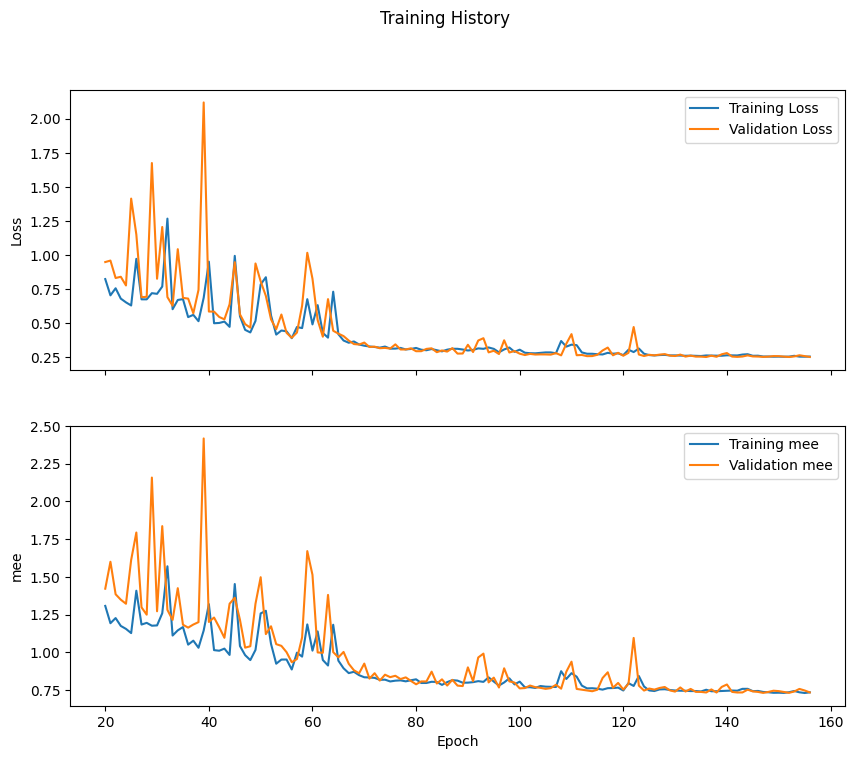

In [10]:
model_to_test = keras_mlp([
    ('dense', 25),
    ('dense', 50),
    ('dense', 150)
])
#Best combo: {'learning_rate': 0.005, 'weight_decay': 0.0005, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}, with values: (0.05887814909219742, 0.43884475231170655)
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, cooldown=10, verbose=1,
                      factor=0.5,
                      min_lr=1e-7,
                      min_delta=1e-7),
    EarlyStopping(monitor='val_loss', start_from_epoch=100, patience=20,
                  min_delta=1e-7)
]
optim = k.optimizers.SGD(learning_rate=0.0045, momentum=0.9, weight_decay=0.000, nesterov=True)
hst = keras_train(model_to_test, train_data=(X_train, y_train), val_data=(X_val, y_val), epochs=350, batch_size=50,
                  optimizer=optim, callback=callbacks)
plot_keras_history(hst, 20)

In [11]:
grid(prev_best, [
    ('dense', 150),
    ('dense', 50),
    ('dense', 25)
])

Layer configuration: [('dense', 150), ('dense', 50), ('dense', 25)]
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True}
Train Loss: mean - 0.2901726961135864 std - 0.02919695284975378, Val Loss: mean - 0.38309082984924314 std - 0.1101678610008657
--------------------------------
New best parameters
--------------------------------
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': False}
Train Loss: mean - 0.8143563747406006 std - 0.13279081945810345, Val Loss: mean - 0.9140349626541138 std - 0.14852575674306534
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': True}
Train Loss: mean - 0.5419698536396027 std - 0.15009958026081305, Val Loss: mean - 0.634489917755127 std - 0.13669712720758434
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': False}
Train Loss: mean - 0.4149848103523

Epoch 1/150
3/3 [==============================] - 0s 46ms/step - loss: 38.5851 - mee: 8.5095 - val_loss: 30.3557 - val_mee: 7.5324 - lr: 0.0100
Epoch 2/150
3/3 [==============================] - 0s 29ms/step - loss: 13.8221 - mee: 4.8387 - val_loss: 12.2560 - val_mee: 5.3495 - lr: 0.0100
Epoch 3/150
3/3 [==============================] - 0s 38ms/step - loss: 11.3442 - mee: 5.2448 - val_loss: 8.6446 - val_mee: 4.4151 - lr: 0.0100
Epoch 4/150
3/3 [==============================] - 0s 32ms/step - loss: 9.4819 - mee: 4.6649 - val_loss: 6.6372 - val_mee: 3.7097 - lr: 0.0100
Epoch 5/150
3/3 [==============================] - 0s 26ms/step - loss: 5.5578 - mee: 3.2892 - val_loss: 5.0968 - val_mee: 3.1512 - lr: 0.0100
Epoch 6/150
3/3 [==============================] - 0s 13ms/step - loss: 3.3244 - mee: 2.6269 - val_loss: 4.1766 - val_mee: 3.0836 - lr: 0.0100
Epoch 7/150
3/3 [==============================] - 0s 13ms/step - loss: 2.9765 - mee: 2.5153 - val_loss: 2.1158 - val_mee: 2.1370 - lr: 0

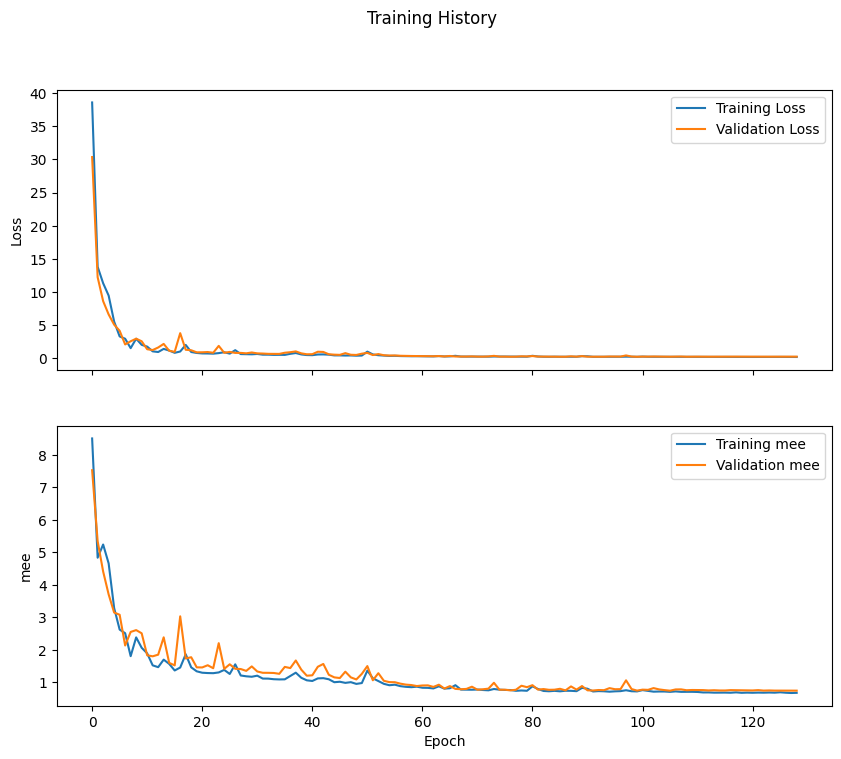

In [12]:
model_to_test = keras_mlp([
    ('dense', 150),
    ('dense', 50),
    ('dense', 25)
])

optim = k.optimizers.SGD(learning_rate=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)

hst = keras_train(model_to_test, train_data=(X_train, y_train), val_data=(X_val, y_val), epochs=150, batch_size=50,
                  optimizer=optim, callback=callbacks)

plot_keras_history(hst)


In [13]:
grid(prev_best, [
    ('dense', 300),
    ('dense', 300),
    ('dense', 300),
    ('dense', 300)
])

Layer configuration: [('dense', 300), ('dense', 300), ('dense', 300), ('dense', 300)]
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True}
Train Loss: mean - 0.3687602460384369 std - 0.05037463573541867, Val Loss: mean - 0.527477478981018 std - 0.18632691519537517
--------------------------------
New best parameters
--------------------------------
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': False}
Train Loss: mean - 0.39634807109832765 std - 0.10570341502379245, Val Loss: mean - 0.4409302115440369 std - 0.12917250242852213
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': True}
Train Loss: mean - 0.773047935962677 std - 0.217612687482383, Val Loss: mean - 0.9418697476387023 std - 0.273908995008201
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': False}
Train Loss: mean - 0

In [14]:
grid(prev_best, [
    ('dense', 500),
    ('dense', 500),
    ('dense', 300),
    ('dense', 300),
    ('dense', 150),
])

Layer configuration: [('dense', 500), ('dense', 500), ('dense', 300), ('dense', 300), ('dense', 150)]
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True}
Train Loss: mean - 0.4805333733558655 std - 0.4096794929879374, Val Loss: mean - 0.4279768347740173 std - 0.10583257465113985
--------------------------------
New best parameters
--------------------------------
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': False}
Train Loss: mean - 0.7810210704803466 std - 0.34451168580272246, Val Loss: mean - 0.651149582862854 std - 0.17367989172381676
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': True}
Train Loss: mean - 0.9809469521045685 std - 0.7472184611357581, Val Loss: mean - 1.0785385847091675 std - 0.4346637889491913
Training with parameters: {'learning_rate': 0.005, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': False}
Tra

Model: "model_1602"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1603 (InputLayer)     [(None, 12)]              0         
                                                                 
 dense_7048 (Dense)          (None, 300)               3900      
                                                                 
 dense_7049 (Dense)          (None, 300)               90300     
                                                                 
 dense_7050 (Dense)          (None, 300)               90300     
                                                                 
 dense_7051 (Dense)          (None, 300)               90300     
                                                                 
 dense_7052 (Dense)          (None, 3)                 903       
                                                                 
Total params: 275703 (1.05 MB)
Trainable params: 275703 

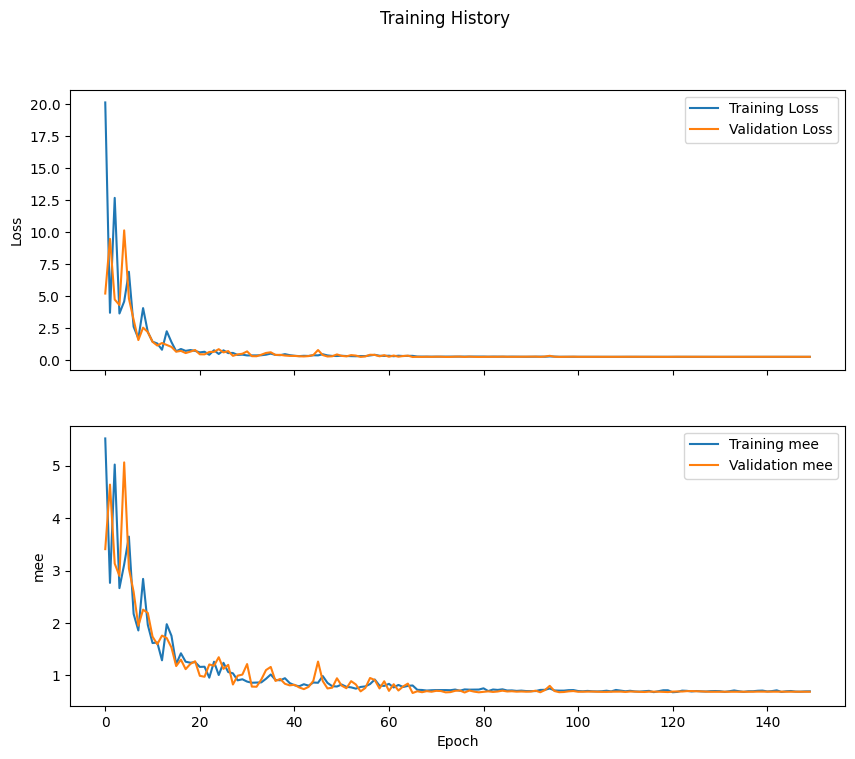

In [15]:
#Best parameters: {'learning_rate': 0.005, 'weight_decay': 0.001, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}, with values: (18.03679656982422, 18.47313709259033)
model_to_test = keras_mlp([
    ('bn', 1),
    ('dense', 300),
    ('dense', 300),
    ('dense', 300),
    ('dense', 300)
])
model_to_test.summary()
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, cooldown=20, verbose=1,
                      factor=0.25,
                      min_lr=1e-7,
                      min_delta=1e-7)
]
history = keras_train(model_to_test, train_data=(X_train, y_train), val_data=(X_val, y_val), epochs=150,
                      optimizer=k.optimizers.SGD(learning_rate=0.005, momentum=0.9, weight_decay=0.001, nesterov=True),
                      callback=callbacks)
plot_keras_history(history)

In [16]:
from tensorflow.keras.callbacks import LearningRateScheduler

model_to_test = keras_mlp([
    ('dense', 350),
    ('dense', 350),
    ('dense', 150),
    ('dense', 150),
])


def scheduler(epochs, lr):
    newlr = lr
    if epochs % 100 == 0:
        newlr = lr * 0.5
    return newlr


callbacks = [
    LearningRateScheduler(scheduler)
]
#Best combo: {'learning_rate': 0.001, 'weight_decay': 0.0001, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'}, with values: (0.0807236298918724, 0.35102823972702024)

optim = k.optimizers.SGD(learning_rate=0.001, momentum=0.9, weight_decay=0.0001, nesterov=True)
hst = keras_train(model_to_test, train_data=(X_train, y_train), val_data=(X_val, y_val), epochs=350,
                  optimizer=optim, callback=callbacks)

Epoch 1/350
5/5 [==============================] - 1s 22ms/step - loss: 39.0153 - mee: 8.8073 - val_loss: 37.5723 - val_mee: 9.0778 - lr: 5.0000e-04
Epoch 2/350
5/5 [==============================] - 0s 12ms/step - loss: 20.0488 - mee: 6.0472 - val_loss: 18.8753 - val_mee: 5.8627 - lr: 5.0000e-04
Epoch 3/350
5/5 [==============================] - 0s 10ms/step - loss: 8.9813 - mee: 3.5711 - val_loss: 8.9180 - val_mee: 4.0537 - lr: 5.0000e-04
Epoch 4/350
5/5 [==============================] - 0s 11ms/step - loss: 5.6115 - mee: 3.2841 - val_loss: 6.7428 - val_mee: 3.9856 - lr: 5.0000e-04
Epoch 5/350
5/5 [==============================] - 0s 11ms/step - loss: 5.9858 - mee: 3.6947 - val_loss: 6.2601 - val_mee: 3.8511 - lr: 5.0000e-04
Epoch 6/350
5/5 [==============================] - 0s 10ms/step - loss: 5.2179 - mee: 3.4100 - val_loss: 5.4698 - val_mee: 3.4365 - lr: 5.0000e-04
Epoch 7/350
5/5 [==============================] - 0s 12ms/step - loss: 3.9872 - mee: 2.8448 - val_loss: 5.3124 - 

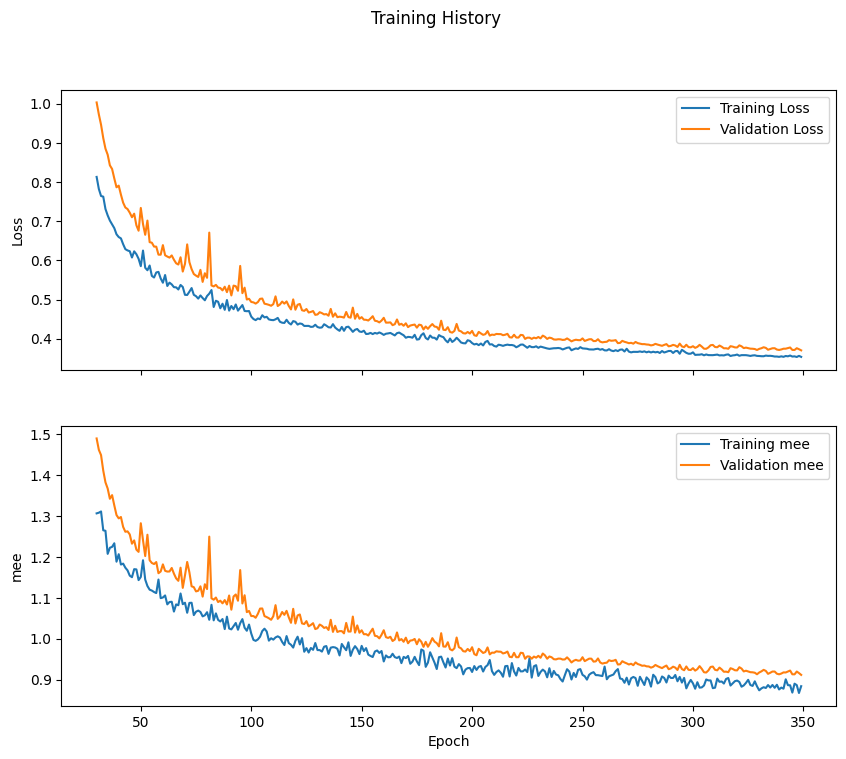

In [17]:
plot_keras_history(hst, 30)